# HW 2 Part 2

Suppose that you had to redo the work you did in Part 1 for different group of HICP indices. You could duplicate that notebook (right click on the name of a notebook anc choose Duplicate, or press Ctrl+d), replace the list of subindices and then run the remaining cells. However, this is not very efficient and violates a basic principle of programming, known as __DRY__ - don't repeat yourself. A better approach is to write functions and automate, whenever possible, tasks which are repeated.

Your task in this part of the homework is to replace parts of the code in Part 1 with functions.

In [1]:
# import the necessary packages
import io
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline

__2.0__ Get the `hicp_codes` dataframe as in Part 1.

In [2]:
#import the HICP Code List Description table from the ECB’s SDW site here into a pandas dataframe.
url = 'https://sdw.ecb.europa.eu/datastructure.do?conceptMnemonic=ICP_ITEM&datasetinstanceid=122#cl'

r  = requests.get(url, headers={"Accept": "text/csv"})    
hicp_codes = pd.read_html(r.text)[1]
hicp_codes.set_index('Code', inplace=True)
hicp_codes

,Code Description
Code,
000000,HICP - Overall index
010000,HICP - FOOD AND NON-ALCOHOLIC BEVERAGES
011000,HICP - Food
011100,HICP - Bread and cereals
011110,HICP - Rice
...,...
XESEAS,HICP - All-items excluding energy and seasonal...
XFROOP,HICP - All-items excluding frequent out-of-poc...
XFUELL,HICP - All-items excl. liquid fuels and fuels ...


__2.1__ Write a function which takes as input an `item group code` pattern (a string) and returns two lists - one of the codes and the other - of the code descriptions of all items in that item group. With that function you should be able to get any group of items for any level of aggregation. Test the function for the group of indices you downloaded in Part 1, and several other groups to make sure it returns the correct lists. For example try "HICP - Overall index" (one item), all items from "HICP - FOOD AND NON-ALCOHOLIC BEVERAGES" (75 items), all items from "HICP - Food" (65 items), etc.

Use the function to get the codes and descriptions of the item group you got in __1.2__ of Part 1.


__Note:__ the function will use `hicp_codes` which you should have created in __2.0__


In [3]:

def cod(x,y):
    if y==1:
        number = [c for c in hicp_codes.index if c.startswith(f'0{x}') & c.endswith('0000')]
    elif y==2:
        number = [c for c in hicp_codes.index if c.startswith(f'0{x}') & c.endswith('000') if not c.endswith('0000')]
    elif y==3:
        number = [c for c in hicp_codes.index if c.startswith(f'0{x}') & c.endswith('00') if not c.startswith(f'0.0') | c.endswith('000')]
    else:
        number = [c for c in hicp_codes.index if c.startswith(f'0{x}')]
    
    return hicp_codes.loc[number,['Code Description']]

In [4]:
len(cod(1,4))

75

In [5]:
len(cod(11,4))

65

In [6]:
cod(93,3)

,Code Description
Code,
093100,"HICP - Games, toys and hobbies"
093200,"HICP - Equipment for sport, camping and open-a..."
093300,"HICP - Gardens, plants and flowers"
093400,HICP - Pets and related products
093500,HICP - Veterinary and other services for pets


In [7]:
codes=cod(9,3)

In [8]:
codes=codes.index.tolist()
codes

['091100',
 '091200',
 '091300',
 '091400',
 '091500',
 '092100',
 '092200',
 '092300',
 '093100',
 '093200',
 '093300',
 '093400',
 '093500',
 '094100',
 '094200',
 '095100',
 '095200',
 '095300',
 '095400']

__2.2__ Write a function which takes a HICP item code (a string) and returns a dataframe like the one in __1.3__ of Part 1 - datetime index and only one series with the item code as column name.

In [9]:
def dow(x):
    
    SDW_URL = "https://sdw-wsrest.ecb.europa.eu/service/data"
    series_code = f'ICP/M.U2.N.{x}.4.ANR'
    ecburl = f"{SDW_URL}/{series_code}"
    response = requests.get(ecburl, headers={"Accept": "text/csv"})
    assert response.status_code == 200, 'Failed to get a correct reponse'

    df_series = pd.read_csv(io.StringIO(response.text))
    df_series = df_series[["TIME_PERIOD", "OBS_VALUE"]].copy()

    df_series.columns.values[0]='date'
    df_series.columns.values[1]=x

    new_index = pd.to_datetime(df_series.date)
    df_series.index=new_index

    df_series.drop('date', axis=1, inplace=True)
    
    return df_series

In [10]:
dow('091100')

,091100
date,
1997-01-01,-3.6
1997-02-01,-3.6
1997-03-01,-3.6
1997-04-01,-3.7
1997-05-01,-3.9
...,...
2021-09-01,0.3
2021-10-01,0.8
2021-11-01,1.7


__2.3__ Copy the code you wrote in Part 1 for __1.4__ and replace the relevant part in the for loop using the function you created above. Check that it gives you the same dataframe as in Part 1.

In [11]:
list_of_dfs = []

for c in codes:
    try:
        data_f=dow(c)
        list_of_dfs.append(data_f)
    except:
         pass
df_hicp_all = pd.concat(list_of_dfs, axis=1)
df_hicp_all


,091100,091200,091300,091400,091500,092100,092200,092300,093100,093200,093300,093400,093500,094100,094200,095100,095200,095300,095400
date,,,,,,,,,,,,,,,,,,,
1997-01-01,-3.6,-3.5,-5.9,-0.1,2.6,NaN,NaN,0.7,1.3,-0.2,1.0,NaN,NaN,3.9,5.0,4.2,2.5,NaN,NaN
1997-02-01,-3.6,-3.9,-6.0,-0.1,2.4,NaN,NaN,0.7,0.9,-0.3,1.1,NaN,NaN,3.8,4.9,3.9,2.2,NaN,NaN
1997-03-01,-3.6,-3.8,-6.2,-0.2,2.5,NaN,NaN,0.6,0.9,-0.5,0.7,NaN,NaN,4.1,4.9,3.4,2.2,NaN,NaN
1997-04-01,-3.7,-3.9,-6.1,-0.1,2.6,NaN,NaN,0.3,0.9,-0.4,0.1,NaN,NaN,4.2,4.8,3.0,2.1,NaN,NaN
1997-05-01,-3.9,-4.0,-5.5,-0.4,2.3,NaN,NaN,0.4,0.8,-0.5,1.6,NaN,NaN,4.2,4.9,3.2,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,0.3,7.0,2.1,-2.3,0.0,3.5,1.4,-5.6,1.1,1.7,4.2,1.8,2.2,1.7,1.5,1.9,3.5,2.5,1.2
2021-10-01,0.8,6.6,2.1,-1.1,0.6,3.7,1.6,1.6,1.5,1.9,4.6,1.7,2.2,1.5,1.5,1.4,3.5,2.4,1.4
2021-11-01,1.7,8.1,0.6,-2.8,0.5,4.6,2.2,4.5,2.0,3.0,5.1,2.7,2.2,1.9,2.4,1.9,3.6,2.8,0.9


__2.4__ create a new dataframe `df_nona` by dropping all columns in `df` that have more than half of their observations missing

</div> <div class="alert alert-block alert-danger"><b>

Your solution in 1.6 was fine (actually better). Why change it???


In [12]:
def clean(df, thr):
    df_clean=df[df.columns[df.isna().mean()<thr]]
   
    return df_clean

In [13]:

df_nona=clean(df_hicp_all,0.5)
df_nona

,091100,091200,091300,091400,091500,092300,093100,093200,093300,094100,094200,095100,095200
date,,,,,,,,,,,,,
1997-01-01,-3.6,-3.5,-5.9,-0.1,2.6,0.7,1.3,-0.2,1.0,3.9,5.0,4.2,2.5
1997-02-01,-3.6,-3.9,-6.0,-0.1,2.4,0.7,0.9,-0.3,1.1,3.8,4.9,3.9,2.2
1997-03-01,-3.6,-3.8,-6.2,-0.2,2.5,0.6,0.9,-0.5,0.7,4.1,4.9,3.4,2.2
1997-04-01,-3.7,-3.9,-6.1,-0.1,2.6,0.3,0.9,-0.4,0.1,4.2,4.8,3.0,2.1
1997-05-01,-3.9,-4.0,-5.5,-0.4,2.3,0.4,0.8,-0.5,1.6,4.2,4.9,3.2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,0.3,7.0,2.1,-2.3,0.0,-5.6,1.1,1.7,4.2,1.7,1.5,1.9,3.5
2021-10-01,0.8,6.6,2.1,-1.1,0.6,1.6,1.5,1.9,4.6,1.5,1.5,1.4,3.5
2021-11-01,1.7,8.1,0.6,-2.8,0.5,4.5,2.0,3.0,5.1,1.9,2.4,1.9,3.6


__2.5__ Write a functions which takes a dataframe and two dates (strings) - `start` and `end` as arguments and returns a dictionary with two keys: 'code' and 'std' whose values are the code and standard deviation of the most volatile among the series in the dataframe.

Write another function for the least volatile series (with the same arguments and output)

Test your functions with the code you used in __1.7__ and __1.8__ in Part 1 as follows

a) Find the respective start and end dates for the full period and the last 24 months. See if you can do it programmatically, but if you cant think of how, just type them directly.

b) Assign the results to dictionaries such as `dict_max`, `dict_min` (Up to you what names you use)

c) Use the function you created in __2.1__ to get the descriptions for the codes in the two dictionaries from (b)

d) print the output usig f-strngs as in __1.7__ and __1.8__ from Part 1.

In [14]:
def mostsd(df, start, end):
    max_item_code = df.loc[start:end, :].std().idxmax()
    max_item_std = round(df.loc[start:end, :].std().max(), 3)
    d = {
        'code': max_item_code,
        'std': max_item_std
    }
    return d

In [15]:
def leastsd(df, start, end):
    min_item_code = df.loc[start:end, :].std().idxmin()
    min_item_std = df.loc[start:end, :].std().min()
    d = {
        'code': min_item_code,
        'std': min_item_std
    }
    return d

</div> <div class="alert alert-block alert-danger"><b>

```df_hicp_all.index[0]``` etc

is enough, no need to overcomplicate it!

In [16]:
# a)
startfp=df_hicp_all.index[0].strftime('%Y-%m-%d')
endfp=df_hicp_all.index[-1].strftime('%Y-%m-%d')
start_last24=df_hicp_all.index[-24].strftime('%Y-%m-%d')
end_last24=df_hicp_all.index[-1].strftime('%Y-%m-%d')

In [17]:
# b)
dict_max_fp=mostsd(df_hicp_all,startfp,end_last24)
dict_min_fp=leastsd(df_hicp_all,startfp,end_last24)
dict_max_last24=mostsd(df_hicp_all,start_last24,end_last24)
dict_min_last24=leastsd(df_hicp_all,start_last24,end_last24)

In [18]:
dict_max_fp

{'code': '092300', 'std': 8.554}

In [19]:
# c)

desc_max_fp=cod(dict_max_fp['code'][1:4],3)
desc_max_fp=pd.Series(desc_max_fp['Code Description'])

desc_max_last24=cod(dict_max_last24['code'][1:4],3)
desc_max_last24=pd.Series(desc_max_last24['Code Description'])

desc_min_fp=cod(dict_min_fp['code'][1:4],3)
desc_min_fp=pd.Series(desc_min_fp['Code Description'])

desc_min_last24=cod(dict_min_last24['code'][1:4],3)
desc_min_last24=pd.Series(desc_min_last24['Code Description'])

In [20]:
# d)
print(f"For the full period, the most volatile item is {dict_max_fp['code']}, corresponding to {desc_max_fp.to_string(index=False, header=None)}, with a standard deviation of {dict_max_fp['std']}.")
print(f"The least volatile item is {dict_min_fp['code']}, corresponding to {desc_min_fp.to_string(index=False, header=None)}, with a standard deviation of {dict_min_fp['std']}.")
      
print(f"For the last 24 months, the most volatile item is {dict_max_last24['code']}, corresponding to {desc_max_last24.to_string(index=False, header=None)}, with a standard deviation of {dict_max_last24['std']}.")
      
print(f"The least volatile item is {dict_max_last24['code']}, corresponding to {desc_min_last24.to_string(index=False, header=None)}, with a standard deviation of {dict_max_last24['std']}.")

For the full period, the most volatile item is 092300, corresponding to HICP - Mainten. and repair of other major durab..., with a standard deviation of 8.554.
The least volatile item is 095400, corresponding to HICP - Stationery and drawing materials, with a standard deviation of 0.4760595057986181.
For the last 24 months, the most volatile item is 091200, corresponding to HICP - Photographic and cinematographic equip. ..., with a standard deviation of 4.075.
The least volatile item is 091200, corresponding to HICP - Newspapers and periodicals, with a standard deviation of 4.075.


__2.6__ Create a function which takes a series (or dataframe with 1 column) and an integer and creates and __saves__ (as a png file) a plot of the rolling window standard deviations of that series, for a window specified by the integer parameter. The name of the file with the figure should change with code of the series and the integer indicating the window length. For example if the code is '011500' and the window is 36, the name of the figure should be something like 'fig_011500_rolling_std_36.png'. The important parts (in this example) are 011500 and 36 - the rest (fixed part of the file name) you choose as you see best. This can be done using f-string.

Test that the function produces the the same plots as in __1.10__ of Part 1.

</div> <div class="alert alert-block alert-danger"><b>

One function is enough! The purpose of the function is to make a plot for any series not only the most or least volatile one.

In [21]:
def img (df, intg):
    df=df.squeeze()
    df_rol_sd=df.rolling(window=intg).std()
    df_rol_sd.dropna(axis=0, how='all',inplace=True)
                         
    plt.plot(df_rol_sd.index, df_rol_sd)
    plt.xlabel('Date')
    plt.ylabel('Rolling window std')            
    plt.title('Rolling window standard deviations for the most volatile item') 
    plt.savefig(f"fig_{df.name}_rol_sd_{intg}", dpi=300)                     

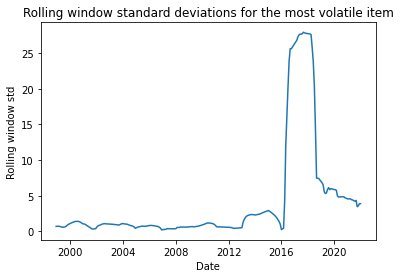

In [22]:
img(df_nona.loc[:,'092300'],24)

In [23]:
def img (df, intg):
    df=df.squeeze()
    df_rol_sd=df.rolling(window=intg).std()
    df_rol_sd.dropna(axis=0, how='all',inplace=True)
                         
    plt.plot(df_rol_sd.index, df_rol_sd)
    plt.xlabel('Date')
    plt.ylabel('Rolling window std')            
    plt.title('Rolling window standard deviations for the most volatile item in the last 24 months') 
    plt.savefig(f"fig_{df.name}_rol_sd_{intg}", dpi=300)     

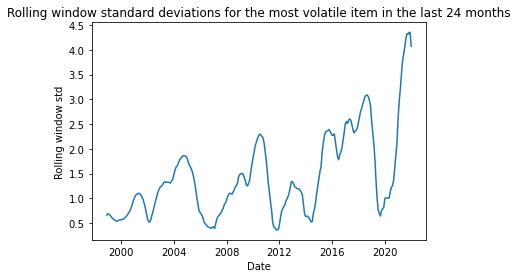

In [24]:
img(df_nona.loc[:,'091200'],24)